In [2]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import logging;
import os;
import time;
from datetime import date, datetime;
from flood_pred_data_processing_V1 import DataProcessor;
from flood_pred_models_V1 import FloodModel;
import seaborn as sns 


Processor = DataProcessor() 
surrey_df = Processor.process_surrey()
# print(surrey_df)
wu_df = Processor.concat_multiple_wu_stations()
# print (wu_df)

Model = FloodModel()  
model_df = Processor.build_model_matrix() 
# model_df.describe().transpose()[['mean', 'std']]

features_df = model_df.drop(columns=['water_level'])
# Normalize the data
normalizer = Model.model_data_normalizer(features_df)
normalized_features = normalizer(features_df.to_numpy())

# Reattach the target column
normalized_data = np.concatenate([normalized_features, model_df[['water_level']].to_numpy()], axis=1)
# Preparing train and test data for LSTM
n_past = 64  # e.g., use 12 hrs past time steps to predict
n_future = 16  # e.g., predict 4 hours ahead
# n_features = dynamic

X_train, y_train = Model.create_lstm_dataset(normalized_data, n_future, n_past)
X_test, y_test = Model.create_lstm_dataset(normalized_data, n_future, n_past)

n_features = normalized_data.shape[1]  # Assuming all columns except the target are features
input_shape = (n_past, n_features)

# Build the LSTM model
model = Model.build_lstm_model(input_shape)
history = Model.train_model(model, X_train, y_train, epochs=40, batch_size=n_past)
bi_direct_lstm_predictions = Model.predict_future(model, X_test)


# X_train, y_train = Model.create_lstm_dataset(normalized_data, n_future, n_past)
# X_test, y_test = Model.create_lstm_dataset(normalized_data, n_future, n_past)

# # Building and training the LSTM model
# lstm_model_wo_water = Model.build_lstm_model((X_train.shape[1], X_train.shape[2]))
# history = Model.train_model(lstm_model_wo_water, X_train, y_train, epochs=50)

# # Predicting future values
# predictions_wo_water = Model.predict_future(lstm_model_wo_water, X_test)





The dataframe is being concatenated


2024-01-18 18:47:32.978061: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40
94/94 [==============================] - 5s 36ms/step - loss: 1.9482 - val_loss: 0.1881
Epoch 2/40
94/94 [==============================] - 3s 34ms/step - loss: 0.0778 - val_loss: 0.1608
Epoch 3/40
94/94 [==============================] - 3s 34ms/step - loss: 0.0221 - val_loss: 0.1322
Epoch 4/40
94/94 [==============================] - 3s 34ms/step - loss: 0.0165 - val_loss: 0.1217
Epoch 5/40
94/94 [==============================] - 3s 34ms/step - loss: 0.0135 - val_loss: 0.1260
Epoch 6/40
94/94 [==============================] - 3s 35ms/step - loss: 0.0131 - val_loss: 0.1297
Epoch 7/40
94/94 [==============================] - 3s 34ms/step - loss: 0.0119 - val_loss: 0.0920
Epoch 8/40
94/94 [==============================] - 3s 34ms/step - loss: 0.0135 - val_loss: 0.0908
Epoch 9/40
94/94 [==============================] - 3s 34ms/step - loss: 0.0123 - val_loss: 0.0984
Epoch 10/40
94/94 [==============================] - 3s 34ms/step - loss: 0.0111 - val_loss: 0.0943
Epoch 11/

In [3]:
# Evaluate the model
mae, mse, rmse, r2, bi_direct_lstm_predictions = Model.evaluate_model(model, X_test, y_test)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}')


208/208 [==============================] - 1s 6ms/step
Mean Absolute Error: 0.055667444934515385
Mean Squared Error: 0.012443843591231851
Root Mean Squared Error: 0.11155197708347374
R² Score: 0.9657094430452297
MAE: 0.055667444934515385, MSE: 0.012443843591231851, RMSE: 0.11155197708347374, R²: 0.9657094430452297


In [4]:

# Create dataset for Scikit-learn model
X_train_lr, y_train_lr = Model.create_sklearn_dataset(normalized_data, n_future, n_past)
X_test_lr, y_test_lr = Model.create_sklearn_dataset(normalized_data, n_future, n_past)

# Build, train, and evaluate the linear regression model
lr_model, lr_mae, lr_mse, lr_rmse, lr_r2, lr_predictions = Model.sklearn_autoregressive_linear_model(X_train_lr, y_train_lr, X_test_lr, y_test_lr)



Scikit-learn Autoregressive Linear Model - MAE: 0.20168702998601828, MSE: 0.11107435818347662, RMSE: 0.3332781993822528, R²: 0.6939208068969295


(6655,)


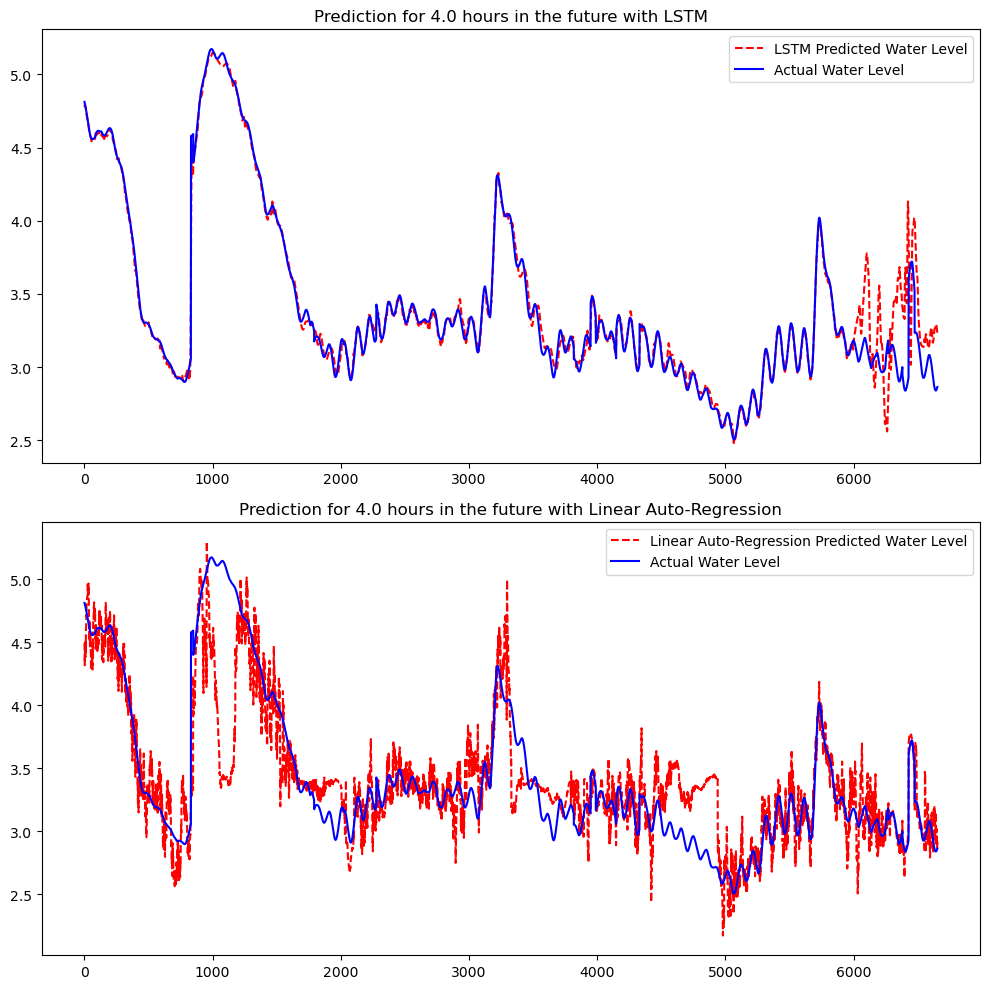

In [12]:
print(lr_predictions.shape)

Model.plot_model_predictions(y_test_lr, [bi_direct_lstm_predictions, lr_predictions],['LSTM', 'Linear Auto-Regression'], 16)

